## Checking the feasibility of the payload

The idea here is to get a sense of what kind of events would be possible to detect by our accelerometer. This model will be a 2D model of 1km x 1km, with the parameters defined as follows.

Velocity of p-wave=3km

Velocity of s_wave=1.5km

Density of the medium(assumed uniform)=2 g/cc

The boundary conditions are as follows:

The top surface has free boundary surface.

The other three surfaces have absorbing boundary conditions(ideally completely).

The impact of the micrometeoroid will be modelled by ricker source(though actually a delta function) which is tuned for the maximum intensity at the frequency of our accelerometer detection.The acceleration is capable of sampling rate from  19.5Hz to 952Hz, but we'll take the middle of capacity which is approximately 500Hz and the more standard 50 HZ also. Also the intensity of the source will be based on the expected force generated by the impact of largest micrometeoroid which we want to analyse.From the payload analysis doc, we have:

time for collision= 1ms

Mass considered=15 micrograms

Velocity=13300km/s

So the average force during the time of impact amounts to approximately 0.2N.


First we'll proceed with the simplest way in our hand and that is to directly use the simple model object as it is and do the analysis.

In [1]:
# Now exploring the details of the examples of the notebooks 1 which is simply the notebook associated with the 
# introduction to seismic modelling in the tutorial. We will use the seismic model object and proceed with model
#calculation


import numpy as np
%matplotlib inline

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


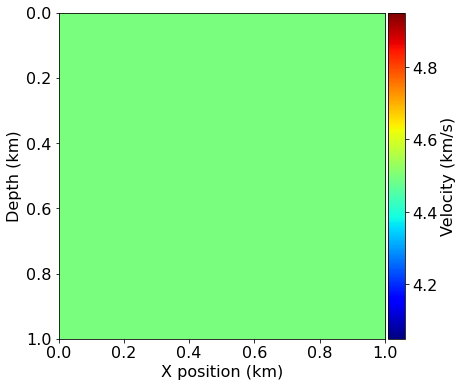

In [2]:

from examples.seismic import ModelElastic, plot_velocity

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
# As the initial model is uniform taking
vp=3*np.ones(shape=shape)
vs=1.5*np.ones(shape=shape)# defining constant velocity at each point in domain

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = ModelElastic(vp=vp,vs=vs,origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp",fs=True)

plot_velocity(model)

# note that here in this plot the sum of the p wave and s wave velocity sum is represented in the entire domain.


In [3]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = 0.02

time_range = TimeAxis(start=t0, stop=tn, step=dt)


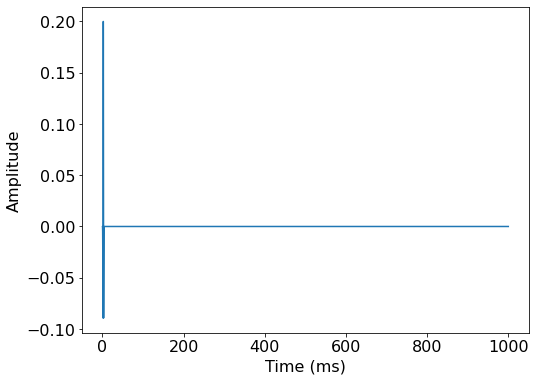

In [4]:
from examples.seismic import RickerSource

f0 = 0.5 # Source peak frequency is 500Hz (0.5 kHz)


src500 = RickerSource(name='src500', grid=model.grid, f0=f0,npoint=1, time_range=time_range,a=0.2)

# First, position source centrally in all dimensions, then set depth
src500.coordinates.data[0, :] = 500
src500.coordinates.data[0, -1] = 0.  # surface collision

# We can plot the time signature to see the wavelet
src500.show()

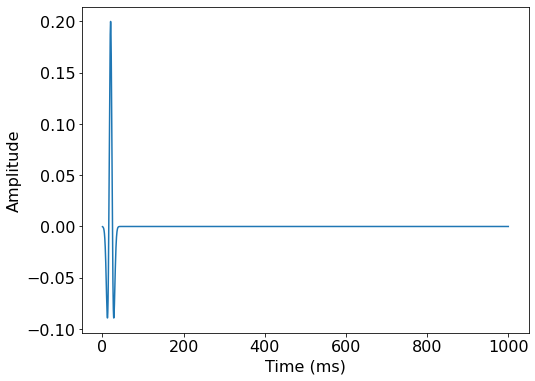

In [5]:
from examples.seismic import RickerSource

f0 = 0.05 # Source peak frequency is 50Hz (0.05 kHz)


src50 = RickerSource(name='src50', grid=model.grid, f0=f0,npoint=1, time_range=time_range,a=0.2)

# First, position source centrally in all dimensions, then set depth
src50.coordinates.data[0, :] = 500
src50.coordinates.data[0, -1] = 0.  # surface collision

# We can plot the time signature to see the wavelet
src50.show()

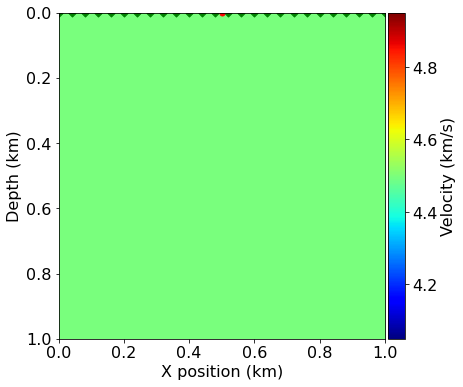

In [6]:

from examples.seismic import Receiver

# we know that our acclerometer can measure the accleration in one direction but for now we'll just keep the source
#reciever to only one dimension.

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 0.  # Recievers are on the surface

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src500.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

In [7]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)
sq_sl=1/(vp[0,0]*vp[0,0])# square slownes
# We can now write the PDE
pde = u.dt2/sq_sl - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + 9.0*Derivative(u(t, x, y), (t, 2))

In [8]:
# This discrete PDE can be solved in a time-matching tway updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))

In [9]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src500.inject(field=u.forward, expr=src500* dt**2 /sq_sl)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward,u_t=time_range,p_t=time_range)

In [10]:
from devito import Operator

op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

In [11]:
op(time=time_range.num-1, dt=2)

Operator `Kernel` run in 0.66 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.5928360000002552, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0025610000000000155, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.05418000000003056, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

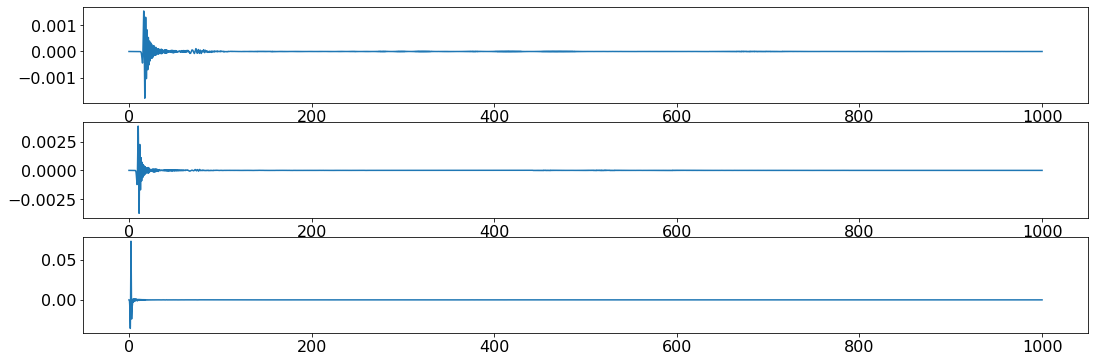

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))

t=np.linspace(0,1000,50001)# the timerange couldn't be used so created this

plt.subplot(3,1,1)
plt.plot(t,rec.data[:,5])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,rec.data[:,25])

plt.subplot(3,1,3)
plt.plot(t,rec.data[:,50])


Now here we are struck in a problem, the source term and the reciever term don't have well documented units, this is as far as we can see.So we can't say much about the feasibility.

The least count of the accelerometer is in milli g s, so does not seem a problem if we belive that the units are compatible.

# The boundary value problem is in next notebook.